In [1]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [183]:
path = "../../Result_json/"
file_list = os.listdir(path)
airflow_files = [file for file in file_list if file.startswith("airflow")]
airbyte_files = [file for file in file_list if file.startswith("airbyte")]

# Sort list
airflow_files = sorted(airflow_files)
airbyte_files = sorted(airbyte_files)

In [184]:
source, target, status = [], [], []
for file, lst in zip(airflow_files, [source, target, status]):
    with open(path + file) as f:
        for line in f:
            temp_json = json.loads(line)
            temp_json['framework'] = "Airflow + Spark"
            lst.append(temp_json)
            
for file, lst in zip(airbyte_files, [source, target]):
    with open(path + file) as f:
        for line in f:
            temp_json = json.loads(line)
            temp_json['framework'] = "Airbyte"
            lst.append(temp_json)        
            
            
status_airbyte = []
with open(path + airbyte_files[-1]) as f:
    for line in f:
        temp_json = json.loads(line)
        temp_json['framework'] = "Airbyte"
        status_airbyte.append(temp_json)                     

In [185]:
source = pd.DataFrame.from_dict(source, orient='columns').explode(["tables_names", "rows_count", "total_size_bytes"]).reset_index(drop=True)
target = pd.DataFrame.from_dict(target, orient='columns').explode(["tables_names", "rows_count", "total_size_bytes"]).reset_index(drop=True)
status = pd.DataFrame.from_dict(status, orient='columns')
status_airbyte = pd.DataFrame.from_dict(status_airbyte, orient='columns')

display(source.head(3))
display(target.head(3))
display(status.head(3))
display(status_airbyte.head(3))

,benchmark_id,operation,start_time,end_time,sf,tables_names,rows_count,total_size_bytes,framework
0,MjAyMzExMDUyMDI4NTc=,populate_db,1.699216e+09,1.699216e+09,3,finwire_sec,2400,942080,Airflow + Spark
1,MjAyMzExMDUyMDI4NTc=,populate_db,1.699216e+09,1.699216e+09,3,watchhistory,900042,61964288,Airflow + Spark
2,MjAyMzExMDUyMDI4NTc=,populate_db,1.699216e+09,1.699216e+09,3,holdinghistory,362342,19292160,Airflow + Spark


,benchmark_id,sf,tables_names,rows_count,total_size_bytes,framework
0,MjAyMzExMDUyMDI4NTc=,3,finwire_fin,98576,29941760,Airflow + Spark
1,MjAyMzExMDUyMDI4NTc=,3,holdinghistory,362342,18931712,Airflow + Spark
2,MjAyMzExMDUyMDI4NTc=,3,hr,15000,2580480,Airflow + Spark


,benchmark_id,startTime,endTime,TimeDelta,operation,framework
0,MjAyMzExMDUyMDI4NTc=,2023-11-05T20:29:35.538302+00:00,2023-11-05T20:30:41.265943+00:00,65.73,sync_airflow,Airflow + Spark
1,MjAyMzExMDUyMDMwNDI=,2023-11-05T20:31:26.833375+00:00,2023-11-05T20:32:47.400895+00:00,80.57,sync_airflow,Airflow + Spark
2,MjAyMzExMDUyMDMyNTA=,2023-11-05T20:33:40.628769+00:00,2023-11-05T20:35:17.692703+00:00,97.06,sync_airflow,Airflow + Spark


,jobId,jobType,startTime,bytesSynced,rowsSynced,TimeDelta,Throughput,operation,benchmark_id,framework
0,67,sync,2023-11-06 01:12:19,596799669,4499457,185,24321.39,sync_airbyte,MjAyMzExMDYwMTExMjI=,Airbyte
1,69,sync,2023-11-06 01:16:29,817802594,6134538,235,26104.42,sync_airbyte,MjAyMzExMDYwMTE1Mjc=,Airbyte
2,71,sync,2023-11-06 01:21:28,1029456475,7754006,297,26107.76,sync_airbyte,MjAyMzExMDYwMTIwMjg=,Airbyte


In [90]:
# Source Fix types
source.rows_count = source.rows_count.astype(int)
source.total_size_bytes = source.total_size_bytes.astype(np.int64)
source.start_time = pd.to_datetime(source.start_time, unit='s')
source.end_time = pd.to_datetime(source.end_time, unit='s')
# Target Fix types
target.rows_count = target.rows_count.astype(int)
target.total_size_bytes = target.total_size_bytes.astype(np.int64)
# Source fix types
status.startTime = pd.to_datetime(status.startTime.str.replace("+00:00", ""), format="%Y-%m-%dT%H:%M:%S.%f")
status.endTime = pd.to_datetime(status.endTime.str.replace("+00:00", ""), format="%Y-%m-%dT%H:%M:%S.%f")
# status_airbyte fix types
status_airbyte.startTime = pd.to_datetime(status_airbyte.startTime, format="%Y-%m-%d %H:%M:%S")

# Source create time_delta
source["time_delta"] = (source.end_time - source.start_time).dt.total_seconds()


In [96]:
source_grouped = source.groupby(["framework", "benchmark_id", "sf"]).agg({"rows_count": "sum", "total_size_bytes": "sum", "time_delta": "max"}).reset_index()
target_grouped = target.groupby(["framework", "benchmark_id", "sf"]).agg({"rows_count": "sum", "total_size_bytes": "sum"}).reset_index()

# join source and status
source_status = source[["framework", "benchmark_id", "sf"]].merge(status, left_on=["framework", "benchmark_id"], right_on=["framework", "benchmark_id"], how="inner")
source_status = source_status.groupby(["framework", "benchmark_id", "sf"]).TimeDelta.max().reset_index()
# join source and status aibyte
source_status_airbyte = source[["framework", "benchmark_id", "sf"]].merge(status_airbyte, left_on=["framework", "benchmark_id"], right_on=["framework", "benchmark_id"], how="inner")
source_status_airbyte = source_status_airbyte.groupby(["framework", "benchmark_id", "sf"]).TimeDelta.max().reset_index()

source_status_combined = pd.concat([source_status, source_status_airbyte])

# Calculate Aiflow + Spark Throughput
temp_join = source_status.merge(target_grouped, left_on=["framework", "benchmark_id", "sf"], right_on=["framework", "benchmark_id", "sf"], how="inner")
temp_join["Throughput"] = temp_join.rows_count / temp_join.TimeDelta
temp_join = temp_join[['framework', 'benchmark_id' , "sf", 'TimeDelta', 'Throughput']]

# target_grouped
df_throughput = status_airbyte[['benchmark_id', 'TimeDelta', 'Throughput', 'framework']].merge(source[['benchmark_id', 'sf', 'framework']], left_on=["framework", "benchmark_id"], right_on=["framework", "benchmark_id"], how="inner")
df_throughput = df_throughput[['framework', 'benchmark_id' , "sf", 'TimeDelta', 'Throughput']]
df_throughput = pd.concat([temp_join, df_throughput])

display(source_grouped.head(3))
display(source_status.head(3))

,framework,benchmark_id,sf,rows_count,total_size_bytes,time_delta
0,Airbyte,MjAyMzExMDYwMTE1Mjc=,4,10632495,555917312,40.783624
1,Airbyte,MjAyMzExMDYwMTExMjI=,3,4499457,406429696,34.584188
2,Airbyte,MjAyMzExMDYwMTI2Mjg=,6,14716680,847421440,51.677029


,framework,benchmark_id,sf,TimeDelta
0,Airflow + Spark,MjAyMzExMDUyMDI4NTc=,3,65.73
1,Airflow + Spark,MjAyMzExMDUyMDM1MTg=,6,113.36
2,Airflow + Spark,MjAyMzExMDUyMDM4MDg=,7,129.45


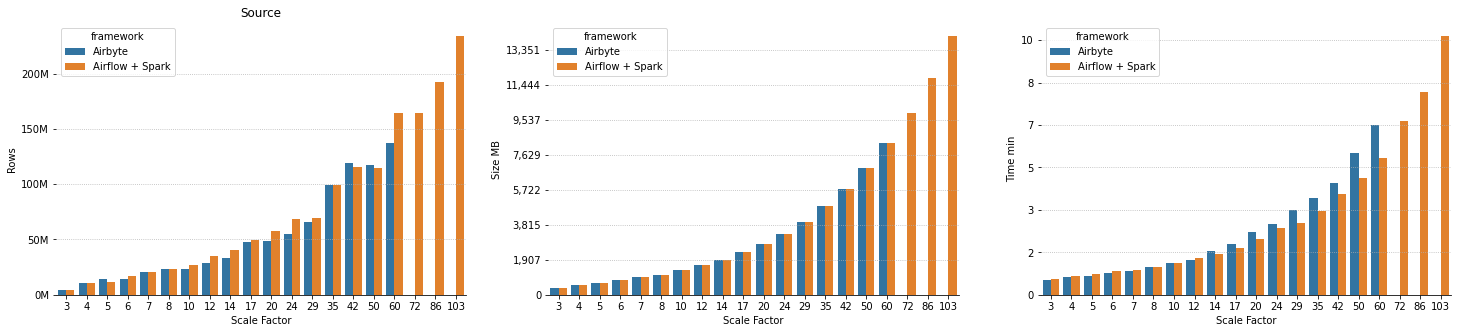

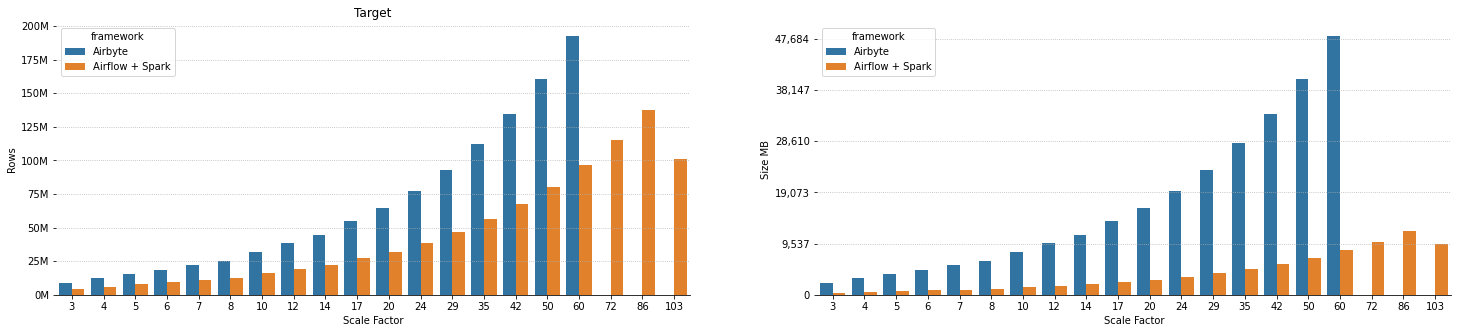

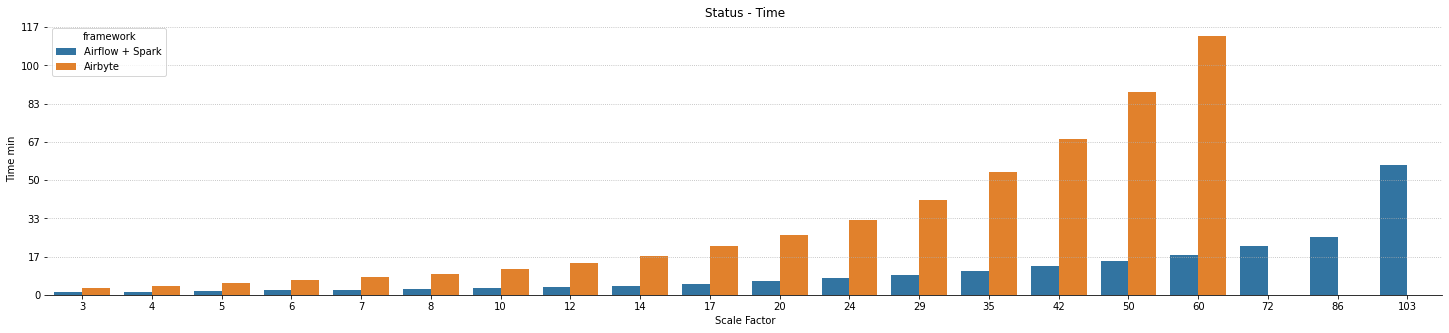

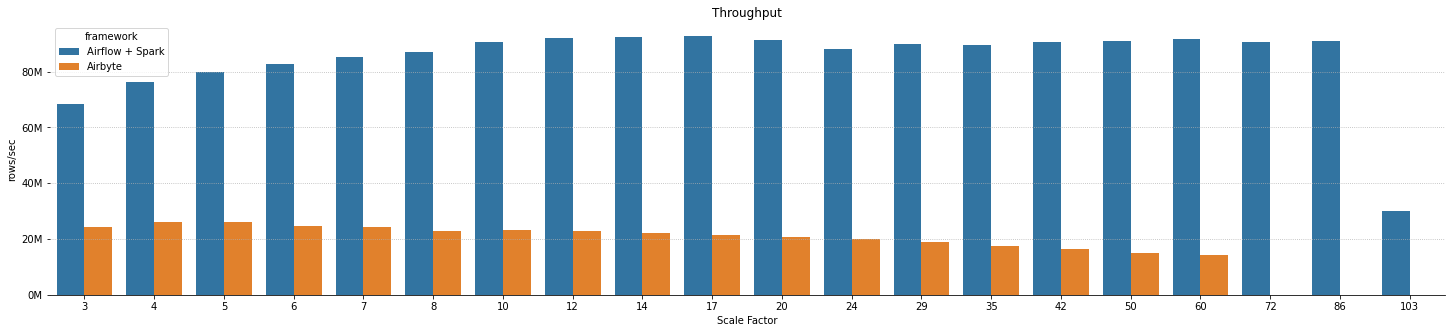

In [236]:
fig, ax = plt.subplots(1, 3, figsize=(25, 5))
# sns.barplot(x="sf", y="time_delta", color="green", data=python_df, ax=ax[2])
for idx, col in enumerate(["rows_count", "total_size_bytes", "time_delta"]):
    g = sns.barplot(x="sf", y=col, hue="framework", data=source_grouped, ax=ax[idx])
    if idx == 0:
        # Set y-axis scale to millions with separators
        ax[idx].yaxis.set_major_formatter(lambda x, pos: '{:,.0f}'.format(x/1000000) + 'M')
        ax[idx].set(ylabel="Rows", xlabel="Scale Factor", title="Source")
    elif idx == 1:
        # Set y-axis frequency to rise by 2000 until 14000
        # ax[idx].yaxis.set_major_locator(range(0, 14000, 2000))
        ax[idx].yaxis.set_major_formatter(lambda x, pos: '{:,.0f}'.format(x/1024/1024))
        ax[idx].set(ylabel="Size MB", xlabel="Scale Factor")
    else:
        ax[idx].yaxis.set_major_formatter(lambda x, pos: '{:,.0f}'.format(x/60))
        ax[idx].set(ylabel="Time min", xlabel="Scale Factor")
    ax[idx].grid(axis='y', linestyle=':')
sns.despine(left=True)
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(25, 5))
for idx, col in enumerate(["rows_count", "total_size_bytes"]):
    sns.barplot(x="sf", y=col, hue="framework", data=target_grouped, ax=ax[idx])
    if idx == 0:
        # Set y-axis scale to millions with separators
        ax[idx].yaxis.set_major_formatter(lambda x, pos: '{:,.0f}'.format(x/1000000) + 'M')
        ax[idx].set(ylabel="Rows", xlabel="Scale Factor", title="Target")
    else:
        # Divide by 1024 to get MB
        ax[idx].yaxis.set_major_formatter(lambda x, pos: '{:,.0f}'.format(x/1024/1024))
        ax[idx].set(ylabel="Size MB", xlabel="Scale Factor")
    ax[idx].grid(axis='y', linestyle=':')
sns.despine(left=True)
plt.show()

fig, ax = plt.subplots(figsize=(25, 5))
sns.barplot(x="sf", y="TimeDelta", hue="framework", data=source_status_combined, ax=ax)
# Set y-axis scale to millions with separators
ax.yaxis.set_major_formatter(lambda x, pos: '{:,.0f}'.format(x/60))
ax.set(ylabel="Time min", xlabel="Scale Factor", title="Status - Time")
ax.grid(axis='y', linestyle=':')
sns.despine(left=True)
plt.show()

fig, ax = plt.subplots(figsize=(25, 5))
sns.barplot(x="sf", y="Throughput", hue="framework", data=df_throughput, ax=ax)
# Set y-axis scale to millions with separators
ax.yaxis.set_major_formatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'M')
ax.set(ylabel="rows/sec", xlabel="Scale Factor", title="Throughput")
ax.grid(axis='y', linestyle=':')
sns.despine(left=True)
plt.show()

In [242]:
target_grouped

,framework,benchmark_id,sf,rows_count,total_size_bytes
0,Airbyte,MjAyMzExMDYwMTE1Mjc=,4,12269103,3218456576
1,Airbyte,MjAyMzExMDYwMTExMjI=,3,8998858,2357903360
2,Airbyte,MjAyMzExMDYwMTI2Mjg=,6,18634616,4926693376
3,Airbyte,MjAyMzExMDYwMTIwMjg=,5,15507738,4058808320
4,Airbyte,MjAyMzExMDYwMTM0MDE=,7,21977346,5770371072
5,Airbyte,MjAyMzExMDYwMTQyNTg=,8,25300911,6630719488
6,Airbyte,MjAyMzExMDYwMTUzMzc=,10,31808964,8341962752
7,Airbyte,MjAyMzExMDYwMjA2Mzg=,12,38265134,10044006400
8,Airbyte,MjAyMzExMDYwMjIyMjQ=,14,44840692,11755085824
9,Airbyte,MjAyMzExMDYwMjQxMjQ=,17,54601273,14319919104
